# Ablation Study Example Notebook

This notebook walks the user through the workflow required to generate comparative plots from RL training experiments in the CoRL framework. This includes training, evaluating and plotting policy performance data. This example will use the safe-autonomy-sims' 3D Satellite Inspection environment.

Author: John McCarroll

## Step 1 - Training

To begin, we will need to train a policy netowrk. For this example, this training job will stand in for a single trial in an assay of tests. It may execute a new RL algorithm, Runtime Assurance algorithm, or simply use a new seed. We will use the base Inspection environment (with PPO and no Runtime Assurance), but configure training to run with different seeds to evaluate the affect of random initialization on the learned policy.

### Step 1a - Setting Seeds

Navigate to the Inspection environment's task config: 'safe-autonomy-sims/configs/tasks/cwh3d_inspection/cwh3d_task.yml'. Find the env_config_updates dict definition (line 24) and add a new item underneath named 'seed'. It should look something like this:

```  
env_config_updates: &env_config_updates
  TrialName: CWH-3D-INSPECTION
  output_path: /tmp/safe_autonomy/
  seed: 11
```

For this example, I will be comparing the seeds 11 and 843.



### Step 1b - Configuring Checkpoints

In this workflow, evaluation data will be generated AFTER training. This means it is crucial to save out checkpoints during training. Using the same task config file from before, let's navigate to the tune_config_updates dict definition (~line 29). We are primarily concerned with the checkpoint_freq (the number of iterations between saved checkpoints) and keep_checkpoints_num (the maximum number of checkpoints to save). Here's an example:

```
tune_config_updates: &tune_config_updates
  local_dir: /tmp/safe_autonomy/ray_results/
  checkpoint_freq: 5
  keep_checkpoints_num: 400
  stop:
    training_iteration: 50
```

Notes: 
    - The 'stop' subdictionary defines training termination criteria. Above, training is configured to terminate after  50 iterations.
    - The string given to the 'local_dir' key is the path at which our training output (and checkpoints) will be saved. Tune will create a new directory with a long name consisting of the TrialName (defined in the environment config), hyperparameter values, and a timestamp. This directory will hold the checkpoints needed for evaluation. We will need to aggregate our experiment output directories into a dict in later steps.



### Step 1c - Running Training

All that is left in this portion is to run CoRL's train_rl.py script. For that we need an experiment config. The Inspection environment's experiment config is located at 'safe-autonomy-sims/configs/experiments/inspection/inspection_3d.yml'. Ensure that this experiment config contains the path to the task config file we modified in the previous step.

To launch a training job, open a  terminal and navigate to the root of your local CoRL repository. Then, enter the command fouund below:

```terminal
$ python -m corl.train_rl --cfg /path/to/inspection/experiment/config
```

## Step 2 - Evaluate Trained Policies

Now that we have trained a couple policies, let's begin setting up to run CoRL's Evaluation Framework in order to generate data for our comparative plot. We will need a PlatformSerializer class, our experiment and task config file paths, a dictionary of experiment name to training output folder path pairs, a plot output path, and a plot config dictionary.

### Step 2a - PlatformSerializer

The Evaluation Framework makes use of a PlatformSerializer class to save and load platform state. These PlatformSerializer classes are specific to the Platforms used in our experiment. We can create a PlatformSerializer for a custom Platform by extending the corl.evaluation.runners.section_factories.plugins.platform_serializer.PlatformSerializer class. Thankfully, we have a PlatformSerializer class prepared for our Inspection environment. We'll import it below, along with the rest of our dependencies.

In [1]:
from corl.evaluation.runners.section_factories.plugins.platform_serializer import PlatformSerializer
from saferl.evaluation.evaluation_api import evaluate, generate_metrics, visualize, checkpoints_list_from_training_output, add_required_metrics
from saferl.evaluation.ablation import run_ablation_study, run_evaluations, create_sample_complexity_plot
# import our serializer for CWH platforms
from saferl.evaluation.launch.serialize_cwh3d import SerializeCWH3D

Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.


### Step 2b - Defining Variables

Now that we have trained a few policies, its time to aggregate and evaluate that data. Let's begin defining some variables needed to run our ablation study. We will need define the paths for our training job's experiment config and task config. We will also define the path where we want our comparative (sample complexity) plot to be saved. Aside from simple paths, there are four key variables to define, which determine much of the function of the evaluation framework. Below, we discuss the details of each variable.


#### Training Output Directories
Create a dictionary of "e### Step 2a - PlatformSerializerxperiment name" to "training output directory path" KVPs. The keys will be used as labels on the generated plot, so feel free to give them semantic meaning to your experiment. See the 'training_output_dirs' variable below for an example. These output directories will be searched for checkpoint subdirectories. policies will be loaded from any found checkpoints and used to run evaluation episodes. 
NOTE: support for grouping experiment trials together coming soon.


#### Plot Config
This dictionary defines the kwargs passed to seaborn's lineplot method to create the sample complexity plot. Only two kwargs are required: 'x_axis' and 'y_axis'. The 'x_axis' variable has three supported units of training time: 'num_interactions', 'num_episodes', and 'iterations'. The 'y_axis' variable is a bit more flexible, as it can be assigned to the name of any Metric fouund in the metrics_config (as long as the Metric has a numeric value). This allows users to create comparative training plots of custom Metrics values (ex. safety violations or runtime assurance interventions). For this example, we will use the TotalReward metric.

Other kwargs can include anything accepted by seaborn's lineplot method. Take 'hue', for example, which groups experiment data together based on categorical data (such as the 'experiment' name column). Another kwarg worth mentioning is 'ci', which stands for 'confidence interval'. This kwarg sets the statistical 'error bound' visualized on the resulting plot. This variable can be an integer (as in 'confidence interval' of 90 percent), but by default 'ci' is assigned the value 'sd' (which stands for one 'standard deviation').


#### Metrics Config
This dict defines the scope, name, class path, and config of every Metric to be calculated during evaluation episodes. The metrics_config has two 'scopes': 'world' and 'agent'. Metrics defined in the 'world' scope apply to the generic Episode data, whereas metrics defined in the 'agent' scope apply specifically to data available to agents. The 'agent' key is assigned a dictionary of lists. The keys are either a specific agent's name or '__default__' (if we want the Metric applied to all agents). The lists contain dictionary definitions of each Metric, which must inclue a 'name', 'functor', and 'config'. See the cell below for a simple example metric_config, defining only the TotalReward Metric in the default agent scope.
If the nested structure of the metrics_config is confusing, it is based off of the yaml config used in CoRL's evaluation framework. The usage guide, fouund (here)[https://github.com/act3-ace/act3-rl/corl/-/blob/main/docs/evaluation_framework/user_guide.md#521-write-the-metrics-configuration-file], contains more details on Metrics configuration.


#### TestCaseManager Config
The TestCaseManager is a class behind the scenes of the evaluation framework responsible for coordinating the initial parameter values used in each evaluation episode or "test case". This config is not required. If a test_case_manager_config kwarg is not defined for the run_ablation_study or evaluate methods, than the task's default ParameterProviders will be used to initialize the environment state for each evaluation episode. If a specific TestCaseStrategy is desired to keep initial evaluation episodes consistent (seeding?***), then one only needs to define two items in the test_case_manager_config dict. The first, 'test_case_strategy_class_path', is the class path to the TestCaseStrategy desired for the evaluation. The second item is 'config', which simply defines the kwargs passed to the TestCaseStrategy's constructor.

Below, the default test_case_manager_config is redundantly defined, for example purposes.

In [2]:
# Define variables

training_output_dirs = {
    'experiment_name1': '/absolute/path/to/training/output/directory',
    'experiment_name2': '/absolute/path/to/training/output/directory2',
}
expr_config = '/absolute/path/to/experiment/config/file.yml'
task_config_path = '/absolute/path/to/task/config/file.yml'
plot_ouput = '/absolute/path/to/desired/plot/save/location.png'

plot_config = {
    "y_axis": "TotalReward",
    "x_axis": "num_iteration"
}

metrics_config = {
    "agent": {
        "__default__": [
            {
                "name": "TotalReward",
                "functor": "corl.evaluation.metrics.generators.rewards.TotalReward",
                "config": {
                    "description": "total reward calculated from test case rollout"
                }
            },
        ]
    }
}

default_test_case_manager_config = {
    "test_case_strategy_class_path": "corl.evaluation.runners.section_factories.test_cases.default_strategy.DefaultStrategy",
    "config": {
        "num_test_cases": 3
    }
}

## Step 3 - Analyze Data

The only thing left to do is launch the evaluation and generate plots. We'll use the run_ablation_study method, which sequentially loads each checkpoint policy, executes the defined evaluation episodes with said policy, calculates Metrics, organizes the data into a pandas.DataFrame, and saves out a seaborn plot to the specified location. It also returns the DataFrame, in case the user wants to do further analysis with the collected data.

/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
2022-12-10 15:23:51,963	INFO trainer.py:2332 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-12-10 15:23:51,964	INFO ppo.py:414 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-12-10 15:23:51,965	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precisio

Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initialize the ray context - ray.init
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


/home/john/AFRL/ACT3/corl/corl/environment/multi_agent_env.py:276: UserWarning: agent 'blue0' has the same name as it's platform.
This is a dangerous configuration and will not be allowed in the future.
  warnings.warn(
/media/john/HDD/anaconda3/envs/safe/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Processed 0 of 3 test cases ---> (0.0%)!!!
Processed 1 of 3 test cases ---> (33.33333333333333%)!!!
Processed 2 of 3 test cases ---> (66.66666666666666%)!!!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Shutdown the ray context - ray.shutdown
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


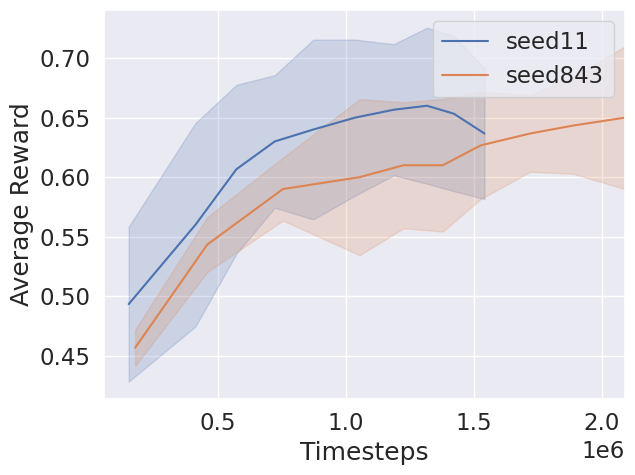

E1210 15:54:59.803521082  570977 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1670705699.803490592","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1670705699.803489075","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":948,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
E1210 16:23:10.987527754  867151 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1670707390.987481697","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1670707390.987480624","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":948,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
E1210 16:24:56.059408714  885336 backup_poller.cc:133]       Run client channel backup poller: {"created

In [3]:
# launch ablation study pipeline
dataframe = run_ablation_study(training_output_dirs, task_config_path, expr_config, metrics_config, SerializeCWH3D, test_case_manager_config=default_test_case_manager_config, plot_output_path=plot_ouput)